In [1]:
import numpy as np
from collections import Counter

In [2]:
def entropy(y):
    histogram = np.bincount(y)
    probabilities = histogram / len(y)
    return - np.sum([probability * np.log2(probability) for probability in probabilities if probability > 0])

In [3]:
class Node:
    def __init__(self, feature= None, threshold= None, left= None, right= None, *, value= None):
        # by using the *, we will only need to use value as the keyword to demarcate it as a leaf node
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def _is_leaf(self):
        return self.value is not None

In [4]:
class DecisionTree:
    def __init__(self, min_samples_split= 2, max_depth= 1500, n_features= None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        y = y.astype(np.int64)
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)
    
    # we use the nodes from the Node class created earlier to make a tree

    def _grow_tree(self, X, y, depth= 0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y)) 
        
        # stopping criterion
        if (depth >= self.max_depth
            or n_labels == 1 #if in a tree, there's only one label
            or n_samples <= self.min_samples_split): #if the samples in the tree are very less
            leaf_value = self._most_common_label(y) #if we reach the leaf node
            return Node(value= leaf_value)
        
        feature_indices = np.random.choice(n_features, self.n_features, replace= False)

        # greedy search
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)
        left_indices, right_indices = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_indices, :], y[left_indices], depth+1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth+1)
        return Node(best_feature, best_threshold, left, right)
    
    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        for feature_index in feature_indices:
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold
        return split_index, split_threshold

    def _information_gain(self, y, X_column, split_threshold):
        # parent entropy
        parent_entropy = entropy(y)

        # generate split
        left_indices, right_indices = self._split(X_column, split_threshold)
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        # weighted average of children entropies
        num_occur = len(y)
        num_left, num_right = len(left_indices), len(right_indices)
        entropy_left, entropy_right = entropy(y[left_indices]), entropy(y[right_indices])
        children_entropy = (num_left / num_occur) * (entropy_left) + (num_right / num_occur) * (entropy_right)

        # return information gain
        information_gain = parent_entropy - children_entropy
        return information_gain

    def _split(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        return left_indices, right_indices

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        # traverse the tree
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node._is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def accuracy(self, y_test, predictions):
        y_test = y_test.astype(np.int64)
        return np.sum(predictions == y_test) / len(y_test)

In [5]:
import pandas as pd
from scipy.io import loadmat

In [6]:
data5 = loadmat('data5.mat')
data = pd.DataFrame(data5['x']) 
data = data.sample(frac= 1, random_state= 3)

In [7]:
X = data.iloc[:, :72]
X = (X - X.mean(axis= 0)) / X.std(axis= 0)
y = data.iloc[:, 72]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [9]:
tree = DecisionTree()

In [10]:
tree.fit(X_train, y_train)

In [11]:
predictions = tree.predict(X_test)

In [12]:
score = tree.accuracy(predictions, y_test)
score

0.8919925512104283

In [13]:
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt

In [14]:
cm = metrics.confusion_matrix(y_test, predictions)

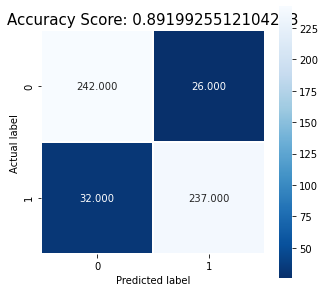

In [15]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()